In [ ]:
!pip install pandas-profiling[notebook]
!pip install lightning
!pip install pytorch-forecasting
!pip install ta
!pip install TA-Lib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.8 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=93329963117f515b6d0c02646ea50d6d7053ad8e217a38359d99ddd1f61d4c72
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd ..
!pip install TA-Lib

--2024-12-16 07:01:48--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-12-16 07:01:49--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:c95, ...
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://onboardcloud.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-12-16 07:01:49--  http://onboardcloud

In [ ]:
from google.colab import drive
from sklearn.impute import KNNImputer
import plotly.graph_objects as go
import pytz

import lightning.pytorch as pl
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting.metrics import CrossEntropy
from pytorch_forecasting.models import BaseModel
from lightning.pytorch.utilities.model_summary import ModelSummary
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import matplotlib.pyplot as plt
import plotly.express as px
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.loggers import CSVLogger
from datetime import timedelta
import os
import warnings


# Define the path for save
base_drive_path = "/content/drive/MyDrive/TFT"
data_path = os.path.join(base_drive_path, "data")
plots_path = os.path.join(base_drive_path, "plots")
model_path = os.path.join(base_drive_path, "model")

# Create directories if they don't exist
os.makedirs(data_path, exist_ok=True)
os.makedirs(plots_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# Constants and configuration parameters
FEATURE_LISTS = {
    "time_varying_known_reals": ["Day", "Month", "Year", "Quarter", "Is_weekend"],
    "time_varying_unknown_categoricals": ["Close_above_MA50", "Close_above_MA200"],
    "time_varying_unknown_reals": [
        "Open", "High", "Low", "Volume", "Close", "MA50", "MA200",
        "SMA_20", "SMA_50", "EMA_12", "EMA_26",
        "Lag_1_Close", "Lag_5_Close", "Lag_1_Volume",
        "Close_MA_5", "Close_MA_10", "Close_MA_20",
        "Close_rolling_std_5", "Close_rolling_std_10", "Close_rolling_std_20",
        "Close_rolling_max_5", "Close_rolling_max_10", "Close_rolling_max_20",
        "Close_rolling_min_5", "Close_rolling_min_10", "Close_rolling_min_20",
        "Daily_price_range", "Range_percent_close", "Volatility_7",
        "Daily_return", "Weekly_return", "Log_Close",
        "RSI", "BB_High", "BB_Low", "MACD", "Signal", "ATR", "OBV"
    ]
}



CONFIG_PARAMS = {
    "max_prediction_length": 22,  # predict 1 month
    "max_encoder_length": 120,     # with 3 bulan data
    "devices": 1,
    "gradient_clip_val": 0,
    "max_epochs": 30,
    "hidden_size": 8,
    "attention_head_size": 1,
    "dropout": 0,
    "hidden_continuous_size": 8,
    "optimizer": "Adam",
    "min_lr": 0.05,
    "max_lr": 0.1,
    "num_training": 200,
    "batch_size": 32,
    "lstm_layers": 2,
}

# Function to configure dataset and dataloaders
def configure_datasets_and_dataloaders(df_filtered, training_cutoff):
    training = TimeSeriesDataSet(
      df_filtered[lambda x: x.time_idx <= training_cutoff],
      time_idx="time_idx",
      target="Close",
      group_ids=["Ticker"],  # assuming "Ticker" is your unique ID per stock
      min_encoder_length=CONFIG_PARAMS["max_encoder_length"] // 2,
      max_encoder_length=CONFIG_PARAMS["max_encoder_length"],
      min_prediction_length=1,
      max_prediction_length=CONFIG_PARAMS["max_prediction_length"],
      static_categoricals=["Ticker"],  # add static features like Ticker here
      time_varying_known_reals=FEATURE_LISTS["time_varying_known_reals"],
      time_varying_unknown_reals=FEATURE_LISTS["time_varying_unknown_reals"],
      time_varying_unknown_categoricals=FEATURE_LISTS["time_varying_unknown_categoricals"],
      target_normalizer=GroupNormalizer(groups=["Ticker"], transformation="softplus"),
      add_relative_time_idx=True,
      add_target_scales=True,
      add_encoder_length=True,
    )

    validation = TimeSeriesDataSet.from_dataset(training, df_filtered, predict=True, stop_randomization=True)

    train_dataloader = training.to_dataloader(train=True, batch_size=CONFIG_PARAMS["batch_size"], num_workers=16, shuffle=False)
    val_dataloader = validation.to_dataloader(train=False, batch_size=CONFIG_PARAMS["batch_size"] * 10, num_workers=16, shuffle=False)

    return train_dataloader, val_dataloader

# Function to create model and trainer
def create_model_and_trainer(train_dataloader, val_dataloader, lr, log_dir):
    logger = CSVLogger(log_dir)
    tft = TemporalFusionTransformer.from_dataset(
        train_dataloader.dataset,
        learning_rate=lr,
        lstm_layers=CONFIG_PARAMS["lstm_layers"],
        hidden_size=CONFIG_PARAMS["hidden_size"],
        attention_head_size=CONFIG_PARAMS["attention_head_size"],
        dropout=CONFIG_PARAMS["dropout"],
        hidden_continuous_size=CONFIG_PARAMS["hidden_continuous_size"],
        loss=QuantileLoss(),
        optimizer=CONFIG_PARAMS["optimizer"],
    )

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()

    trainer = Trainer(
        strategy="ddp_notebook",
        accelerator="cpu",
        devices=CONFIG_PARAMS["devices"],
        precision=16,
        max_epochs=CONFIG_PARAMS["max_epochs"],
        callbacks=[lr_logger, early_stop_callback],
        logger=logger,
    )

    return tft, trainer

Read data

In [ ]:
def plot_candlestick_with_ma(df, ma50_col=None, ma200_col=None, title="Stock Price with Moving Averages"):
    fig = go.Figure(data=[go.Candlestick(
        x=df['Date'],
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name='Candlesticks'
    )])

    if ma50_col and ma50_col in df.columns:
        fig.add_trace(go.Scatter(
            x=df['Date'],
            y=df[ma50_col],
            mode='lines',
            name='50-Day MA',
            line=dict(color='orange', width=2)
        ))

    if ma200_col and ma200_col in df.columns:
        fig.add_trace(go.Scatter(
            x=df['Date'],
            y=df[ma200_col],
            mode='lines',
            name='200-Day MA',
            line=dict(color='blue', width=2)
        ))

    fig.update_layout(
        title=title,
        xaxis_title="Date",
        yaxis_title="Stock Price (USD)",
        xaxis_rangeslider_visible=False
    )

    fig.show()

def plot_line_chart(df, x_col, y_col, title="Line Chart", x_label="X", y_label="Y"):
    fig = px.line(
        df,
        x=x_col,
        y=y_col,
        title=title,
        labels={x_col: x_label, y_col: y_label}
    )

    fig.show()

def fill_missing(df, method="knn", k_neighbors=5):
    if method not in ["knn", "ffill"]:
        raise ValueError("Method must be 'knn' or 'ffill'.")

    df_filled = df.copy()

    if method == "knn":
        print("Filling missing values using KNN...")
        numeric_columns = df_filled.select_dtypes(include=["float64", "int64"]).columns
        imputer = KNNImputer(n_neighbors=k_neighbors)
        df_filled[numeric_columns] = imputer.fit_transform(df_filled[numeric_columns])

    elif method == "ffill":
        print("Filling missing values using forward fill...")
        df_filled.fillna(method="ffill", inplace=True)
        # Backward fill as a fallback for remaining NaNs
        df_filled.fillna(method="bfill", inplace=True)

    return df_filled

def convert_to_jakarta_time(df, datetime_column):
    df[datetime_column] = pd.to_datetime(df[datetime_column], errors='coerce')
    df[datetime_column] = df[datetime_column].dt.tz_localize('UTC', ambiguous='NaT')
    df[datetime_column] = df[datetime_column].dt.tz_convert('Asia/Jakarta')

    return df

def save_plot(fig, plot_name="plot", drive_path=base_drive_path):
    os.makedirs(drive_path, exist_ok=True)
    plot_path = os.path.join(drive_path, f"{plot_name}.png")
    fig.write_image(plot_path)

    print(f"Plot saved at: {plot_path}")



In [ ]:
from google.colab import drive
import pandas as pd

# Function to load data and filter by ticker
def load_and_filter_by_ticker(data_path: str, ticker: str) -> pd.DataFrame:
    # Mount Google Drive
    drive.mount('/content/drive', force_remount=True)

    # Load the Parquet file
    try:
        df = pd.read_parquet(data_path)
        print("Data loaded successfully.")
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

    # Filter data for the specified ticker
    df_filtered = df[df["Ticker"] == ticker]
    print(f"Filtered data for ticker: {ticker}")

    return df_filtered

data_path = "/content/drive/MyDrive/TFT/data/all_stock_data.parquet"
ticker = "NVDA"  # Change this to any ticker you want
df_filtered = load_and_filter_by_ticker(data_path, ticker)

# Display the descriptive statistics of the filtered data
if df_filtered is not None:
    print(df_filtered.describe())


Mounted at /content/drive
Data loaded successfully.
Filtered data for ticker: NVDA
              Open         High          Low        Close        Volume  \
count  6489.000000  6489.000000  6489.000000  6489.000000  6.489000e+03   
mean      7.261967     7.396467     7.116544     7.263210  6.029193e+08   
std      20.051124    20.421014    19.628282    20.041916  4.312803e+08   
min       0.014740     0.015015     0.014080     0.014410  1.968000e+07   
25%       0.117918     0.121227     0.114728     0.117883  3.427640e+08   
50%       0.211830     0.215737     0.208134     0.211516  5.039560e+08   
75%       4.155837     4.216543     4.087790     4.142902  7.345320e+08   
max     143.000000   144.419998   141.779999   143.710007  9.230856e+09   

         Dividends  Stock Splits  
count  6489.000000   6489.000000  
mean      0.000169      0.002080  
std       0.002374      0.072627  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.00000

In [ ]:
import pandas as pd
import numpy as np
import talib  # For technical indicators
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands


def calculate_moving_averages(df, windows=[50, 200]):
    """Calculate moving averages for specified window sizes."""
    for window in windows:
        df[f"MA{window}"] = df["Close"].rolling(window=window).mean()
    return df


def add_price_flags(df):
    """Add flags for close price relative to moving averages."""
    if "MA50" in df and "MA200" in df:
        df["Close_above_MA50"] = (df["Close"] > df["MA50"]).astype(int)
        df["Close_above_MA200"] = (df["Close"] > df["MA200"]).astype(int)
    return df


def extract_date_features(df):
    """Extract day, month, year, quarter, and weekend information."""
    df["Date"] = pd.to_datetime(df["Date"])
    df["Day"] = df["Date"].dt.day
    df["Month"] = df["Date"].dt.month
    df["Year"] = df["Date"].dt.year
    df["Quarter"] = (df["Month"] - 1) // 3 + 1
    df["Is_weekend"] = df["Date"].dt.weekday.isin([5, 6]).astype(int)
    return df


def add_lagged_features(df, lags=[1, 3, 7], columns=["Close", "Volume"]):
    """Add lagged features for specified columns."""
    for col in columns:
        for lag in lags:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return df


def add_rolling_statistics(df, windows=[5, 10, 20]):
    """Add rolling statistics (mean, std, max, min)."""
    for window in windows:
        df[f"Close_MA_{window}"] = df["Close"].rolling(window=window).mean()
        df[f"Close_rolling_std_{window}"] = df["Close"].rolling(window=window).std()
        df[f"Close_rolling_max_{window}"] = df["Close"].rolling(window=window).max()
        df[f"Close_rolling_min_{window}"] = df["Close"].rolling(window=window).min()
    return df


def add_technical_indicators(df):
    """Add technical indicators such as RSI and Bollinger Bands."""
    rsi = RSIIndicator(df["Close"], window=14)
    df["RSI"] = rsi.rsi()

    bb = BollingerBands(df["Close"], window=20, window_dev=2)
    df["BB_High"] = bb.bollinger_hband()
    df["BB_Low"] = bb.bollinger_lband()
    return df


def add_volatility_measures(df):
    """Add volatility and range-based measures."""
    df["Daily_price_range"] = df["High"] - df["Low"]
    df["Range_percent_close"] = (df["High"] - df["Low"]) / df["Close"]
    df["Volatility_7"] = df["Close"].rolling(window=7).std()
    return df


def add_returns(df):
    """Add daily and weekly returns."""
    df["Daily_return"] = df["Close"].pct_change()
    df["Weekly_return"] = df["Close"].pct_change(periods=7)
    return df


def add_log_transformation(df):
    """Apply log transformation to close price."""
    df["Log_Close"] = np.log(df["Close"])
    return df

def calculate_ema_sma(df):
    """Calculate Simple and Exponential Moving Averages."""
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    return df

def calculate_macd(df):
    """Calculate MACD and Signal Line."""
    df['MACD'], df['Signal'], df['MACDhist'] = talib.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    return df

def calculate_rsi(df):
    """Calculate Relative Strength Index (RSI)."""
    df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
    return df

def calculate_bollinger_bands(df):
    """Calculate Bollinger Bands."""
    df['Upper_Band'], df['Middle_Band'], df['Lower_Band'] = talib.BBANDS(
        df['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0
    )
    return df

def calculate_atr(df):
    """Calculate Average True Range (ATR)."""
    df['ATR'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    return df

def calculate_obv(df):
    """Calculate On-Balance Volume (OBV)."""
    df['OBV'] = talib.OBV(df['Close'], df['Volume'])
    return df

def calculate_statistical_features(df):
    """Calculate rolling mean, std, max, and min."""
    df['Rolling_Mean_20'] = df['Close'].rolling(window=20).mean()
    df['Rolling_Std_20'] = df['Close'].rolling(window=20).std()
    df['Rolling_Max_20'] = df['Close'].rolling(window=20).max()
    df['Rolling_Min_20'] = df['Close'].rolling(window=20).min()
    df['Rolling_Max_Min_Diff'] = df['Rolling_Max_20'] - df['Rolling_Min_20']
    return df

def add_lagged_features(df):
    """Add lagged features."""
    df['Lag_1_Close'] = df['Close'].shift(1)
    df['Lag_5_Close'] = df['Close'].shift(5)
    df['Lag_1_Volume'] = df['Volume'].shift(1)
    return df


def preprocess_data(df):
    """
    Perform full preprocessing pipeline:
    - Moving averages
    - Flags
    - Lagged features
    - Rolling statistics
    - Technical indicators
    - Volatility measures
    - Returns
    - Log transformation
    - Handle missing values

    - Moving averages
    - MACD
    - RSI
    - Bollinger Bands
    - ATR
    - OBV
    - Statistical features
    - Lagged features
    """
    df = calculate_moving_averages(df)
    df = add_price_flags(df)
    df = extract_date_features(df)
    df = add_lagged_features(df)
    df = add_rolling_statistics(df)
    df = add_technical_indicators(df)
    df = add_volatility_measures(df)
    df = add_returns(df)
    df = add_log_transformation(df)

    df = calculate_ema_sma(df)
    df = calculate_macd(df)
    df = calculate_rsi(df)
    df = calculate_bollinger_bands(df)
    df = calculate_atr(df)
    df = calculate_obv(df)
    df = calculate_statistical_features(df)
    df = add_lagged_features(df)
    # Handle missing values
    df = df.dropna().reset_index(drop=True)
    return df  # Ensure the DataFrame is returned


if __name__ == "__main__":
    df_filtered = preprocess_data(df_filtered)

    # Display the preprocessed data
    print(df_filtered.head())


        Date Ticker      Open      High       Low     Close        Volume  \
0 1999-11-04   NVDA  0.024420  0.026345  0.024420  0.025684  1.260336e+09   
1 1999-11-05   NVDA  0.026400  0.026620  0.023650  0.024859  6.163680e+08   
2 1999-11-08   NVDA  0.024089  0.026290  0.023319  0.025575  4.700160e+08   
3 1999-11-09   NVDA  0.025520  0.025630  0.024200  0.025189  2.723520e+08   
4 1999-11-10   NVDA  0.025272  0.025300  0.024475  0.024970  1.440480e+08   

   Dividends  Stock Splits      MA50  ...  Upper_Band  Middle_Band  \
0        0.0           0.0  0.020290  ...    0.023898     0.019731   
1        0.0           0.0  0.020353  ...    0.024659     0.019940   
2        0.0           0.0  0.020407  ...    0.025533     0.020212   
3        0.0           0.0  0.020455  ...    0.026220     0.020479   
4        0.0           0.0  0.020460  ...    0.026795     0.020762   

   Lower_Band       ATR           OBV  Rolling_Mean_20  Rolling_Std_20  \
0    0.015564  0.001639  9.999360e+09     

In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6290 entries, 0 to 6289
Data columns (total 59 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  6290 non-null   datetime64[ns]
 1   Ticker                6290 non-null   object        
 2   Open                  6290 non-null   float64       
 3   High                  6290 non-null   float64       
 4   Low                   6290 non-null   float64       
 5   Close                 6290 non-null   float64       
 6   Volume                6290 non-null   float64       
 7   Dividends             6290 non-null   float64       
 8   Stock Splits          6290 non-null   float64       
 9   MA50                  6290 non-null   float64       
 10  MA200                 6290 non-null   float64       
 11  Close_above_MA50      6290 non-null   int64         
 12  Close_above_MA200     6290 non-null   int64         
 13  Day               

In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
from lightning.pytorch import Trainer
from sklearn.preprocessing import MinMaxScaler
import pytorch_lightning as pl

# Automatically select numeric columns (float64 and int64 types)
numeric_columns = df_filtered.select_dtypes(include=['float64', 'int64']).columns

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to numeric columns
df_filtered[numeric_columns] = scaler.fit_transform(df_filtered[numeric_columns])

# Add this line after preprocessing (in the `preprocess_data` function) before returning the DataFrame

df_filtered['time_idx'] = list(range(len(df_filtered)))

# Set the training cutoff and learning rate
training_cutoff = df_filtered["time_idx"].max() - CONFIG_PARAMS["max_prediction_length"]
learning_rate = 0.005  # Example learning rate

for col in FEATURE_LISTS["time_varying_unknown_categoricals"]:
    df_filtered[col] = df_filtered[col].astype(str)

# Configure datasets and dataloaders
train_dataloader, val_dataloader = configure_datasets_and_dataloaders(df_filtered, training_cutoff)

# Set log directory
log_dir = os.path.join(base_drive_path, "logs")

# Create the model and trainer
tft, trainer = create_model_and_trainer(train_dataloader, val_dataloader, learning_rate, log_dir)

# Train the model
trainer.fit(tft, train_dataloader, val_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('sanity_check_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('sanity_check_SMAPE', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('sanity_check_MAE', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('sanity_check_RMSE'

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val_SMAPE', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val_MAE', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val_RMSE', ..., sync_dist=True)` when logging

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Define the directory for saving the model
model_dir = f"/content/drive/MyDrive/TFT/{ticker}/models"
os.makedirs(model_dir, exist_ok=True)

# Save the trained model
model_path = f"{model_dir}/TFT_model_lr_{learning_rate}.ckpt"
trainer.save_checkpoint(model_path)

print(f"Model saved at {model_path}")

Model saved at /content/drive/MyDrive/TFT/NVDA/models/TFT_model_lr_0.005.ckpt


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessiv

Text(0.5, 1.0, 'Prediction on Validation Set with learning_rate = 0.005')

<Figure size 640x480 with 0 Axes>

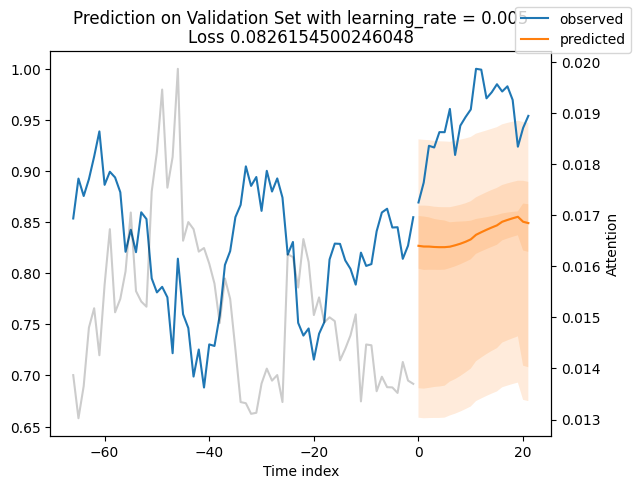

In [ ]:
from pytorch_lightning import Trainer
from pytorch_forecasting import TemporalFusionTransformer
learning_rate = 0.005

model_path = f"{model_dir}/TFT_model_lr_{learning_rate}.ckpt"

# Load the model from the checkpoint
tft = TemporalFusionTransformer.load_from_checkpoint(model_path)

val_predictions = tft.predict(val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))

# Plot predictions
plt.figure()
tft.plot_prediction(val_predictions.x, val_predictions.output, idx=0, add_loss_to_title=True)
plt.title(f"Prediction on Validation Set with learning_rate = {learning_rate}", pad=20)